# Strategy

In this notebook, we attempt to train an inverse dynamics model (IDM). In Reinforcement Learning parlance, an IDM learns to predict $a_t$ given $s_t$ and $s_{t+1}$. In our case, we have access to the MetaDrive simulator and the Waymo dataset. We want to predict the action the car should take in MetaDrive so that the successor state in the simulator is as close as possible to the successor state in the Waymo dataset.

In [ ]:
# CHANGE ME: Set this to the path to the Waymo Open Dataset root directory
WAYMO_DATA_PATH = "~/data/waymo"

In [2]:
import typing
from dataclasses import dataclass
import numpy as np
import numpy.typing as npt

@dataclass
class State:
    heading: float
    velocity: npt.NDArray[np.float64]


Observation: typing.TypeAlias = tuple[State, State]
Action: typing.TypeAlias = tuple[float, float]

In [ ]:
import os

trajectories: list[list[State]] = []


def getFiles(path: str) -> list[str]:
    path = os.path.expanduser(path)
    files = [os.path.join(path, f) for f in os.listdir(path)]
    return [f for f in files if os.path.isfile(f)]

file_iter = iter(getFiles(WAYMO_DATA_PATH))

In [ ]:
# tensorflow don't allocate all gpu memory right away
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
from waymo_protos import scenario_pb2

def parse_scenario(scenario: scenario_pb2.Scenario) -> list[State]:
    states = []
    for s in scenario.tracks[scenario.sdc_track_index].states:
        if s.valid:
            states.append(State(s.heading, np.array([s.velocity_x, s.velocity_y], dtype=np.float32)))
    return states

for file_path in file_iter:
    trajectories_in_file = []
    for data in tf.data.TFRecordDataset(file_path, compression_type="").as_numpy_iterator():
        scenario = scenario_pb2.Scenario()
        scenario.ParseFromString(data)
        trajectories_in_file.append(parse_scenario(scenario))
    trajectories.extend(trajectories_in_file)
    print(f"Loaded {len(trajectories_in_file)} trajectories from {file_path}")

In [3]:
import pickle
import os
import lzma

# pickle the trajectories
if not os.path.exists('waymo_data/trajectories.pkl.xz'):
    with lzma.open('waymo_data/trajectories.pkl.xz', 'wb') as f:
        pickle.dump(trajectories, f)

In [4]:
import pickle
import os
import lzma

# unpickle and decompress
if "trajectories" not in locals():
    with lzma.open('waymo_data/trajectories.pkl.xz', 'rb') as f:
        trajectories = pickle.load(f)

In [5]:
import random

idm_data: list[Observation] = []
for states in trajectories:
    for i in range(len(states)-1):
        idm_data.append((states[i], states[i+1]))

# 90:10 train-validation split
random.seed(0)
random.shuffle(idm_data)
idm_train_data = idm_data[:int(len(idm_data)*0.9)]
idm_validation_data = idm_data[int(len(idm_data)*0.9):]

In [6]:
print("train data:", len(idm_train_data))
print("validation data:", len(idm_validation_data))

train data: 399502
validation data: 44390


In [7]:
import matplotlib.pyplot as plt
import metadrive
from metadrive import MetaDriveEnv
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F



def deviceof(m: nn.Module) -> torch.device:
    """
    Get the device of the given module
    """
    return next(m.parameters()).device

def normalize_angle(angle: float) -> float:
    """
    Normalize the angle to [-pi, pi)
    """
    return (angle + np.pi) % (2 * np.pi) - np.pi

def get_metadrive_state(env: MetaDriveEnv) -> State:
    return State(heading=env.vehicle.heading_theta, velocity=env.vehicle.velocity[:2])

def next_state(env: MetaDriveEnv, s: State, a: Action) -> State:
    """
    runs the policy and returns the total reward
    """
    # reset
    env.reset()
    env.vehicle.set_position(env.vehicle.position, height=0.49)

    # allow car to settle
    for _ in range(5):
        env.step([0,0])

    # set the initial state
    env.vehicle.set_velocity(s.velocity)
    env.vehicle.set_heading_theta(s.heading)
    
    # run the simulator
    env.step(a)

    # get the new state
    s_prime = get_metadrive_state(env)

    # allow car to settle (if rendering)
    if env.config.use_render:
        for _ in range(10):
            env.step([0,0])

    return s_prime

def gen_random_action() -> Action:
    """
    Generates a random action with probabilities that are similar to that are found in the waymo dataset
    """
    a = tuple(np.random.normal(0, 0.5, 2))
    return a

def state_batch_to_tensor(states: list[State], device: torch.device) -> torch.Tensor:
    """
    Reshape the state from State to a tensor of shape (batch_size, 4)
    """
    velocities = torch.tensor(np.stack([st.velocity for st in states]), dtype=torch.float32, device=device)
    heading = torch.tensor([st.heading for st in states], dtype=torch.float32, device=device)
    return torch.cat([velocities, torch.cos(heading).unsqueeze(1), torch.sin(heading).unsqueeze(1)], dim=1)

def action_batch_to_tensor(actions: list[Action], device: torch.device) -> torch.Tensor:
    """
    Reshape the action from Action to a tensor of shape (batch_size, 2)
    """
    return torch.tensor(np.stack(actions), dtype=torch.float32, device=device)

def obs_batch_to_tensor(obs: list[Observation], device: torch.device) -> torch.Tensor:
    """
    Reshape the observation from tuple[State, State] to a tensor of shape (batch_size, 4, 2)
    """

    observations = []

    for st0, st1 in obs:
        observations.append(np.array([
            [st0.velocity[0], st1.velocity[0]], 
            [st0.velocity[1], st1.velocity[1]],
            [np.cos(st0.heading), np.cos(st1.heading)],
            [np.sin(st0.heading), np.sin(st1.heading)],
        ]))

    return torch.tensor(np.stack(observations), dtype=torch.float32, device=device)

Successfully registered the following environments: ['MetaDrive-validation-v0', 'MetaDrive-10env-v0', 'MetaDrive-100envs-v0', 'MetaDrive-1000envs-v0', 'SafeMetaDrive-validation-v0', 'SafeMetaDrive-10env-v0', 'SafeMetaDrive-100envs-v0', 'SafeMetaDrive-1000envs-v0', 'MARLTollgate-v0', 'MARLBottleneck-v0', 'MARLRoundabout-v0', 'MARLIntersection-v0', 'MARLParkingLot-v0', 'MARLMetaDrive-v0'].


This task may take a few minutes to run the first time.

In [6]:
def generate_data(s0_batch: list[State]) -> list[tuple[State, Action, State]]:
    env = MetaDriveEnv(config={"on_continuous_line_done": False, "use_render": False})
    dataset: list[tuple[State, Action, State]] = []
    for s0 in s0_batch:
        a = gen_random_action()
        s1 = next_state(env, s0, a)
        dataset.append((s0, a, s1))
    env.close()
    return dataset

In [109]:
from concurrent.futures import ProcessPoolExecutor
from metadrive import MetaDriveEnv

MAX_WORKERS = 16

mm_train_data: list[tuple[State, Action, State]] = []

with ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
    batch_size, leftover_size = divmod(len(idm_train_data), MAX_WORKERS)
    
    # Distribute the data evenly among workers
    n_scenarios_per_worker = [batch_size]*MAX_WORKERS
    n_scenarios_per_worker[0] += leftover_size

    # Distribute the initial states among workers
    idm_train_data_iter = iter(idm_train_data)
    s0_batch_per_worker = [[next(idm_train_data_iter)[0] for _ in range(n_scenarios)] for n_scenarios in n_scenarios_per_worker]

    # Generate the data in parallel
    for batch in executor.map(generate_data, s0_batch_per_worker):
        mm_train_data.extend(batch)

:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warn

In [111]:
from concurrent.futures import ProcessPoolExecutor
from metadrive import MetaDriveEnv

MAX_WORKERS = 16

mm_validation_data: list[tuple[State, Action, State]] = []

with ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
    batch_size, leftover_size = divmod(len(idm_validation_data), MAX_WORKERS)
    
    # Distribute the data evenly among workers
    n_scenarios_per_worker = [batch_size]*MAX_WORKERS
    n_scenarios_per_worker[0] += leftover_size

    # Distribute the initial states among workers
    idm_train_data_iter = iter(idm_train_data)
    s0_batch_per_worker = [[next(idm_train_data_iter)[0] for _ in range(n_scenarios)] for n_scenarios in n_scenarios_per_worker]

    # Generate the data in parallel
    for batch in executor.map(generate_data, s0_batch_per_worker):
        mm_validation_data.extend(batch)

:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warn

In [112]:
import pickle
import os
import lzma

# pickle the data
if not os.path.exists('waymo_data/mm_train_data.pkl.xz'):
    with lzma.open('waymo_data/mm_train_data.pkl.xz', 'wb') as f:
        pickle.dump(mm_train_data, f)

if not os.path.exists('waymo_data/mm_validation_data.pkl.xz'):
    with lzma.open('waymo_data/mm_validation_data.pkl.xz', 'wb') as f:
        pickle.dump(mm_validation_data, f)



In [8]:
import pickle
import os
import lzma

if 'mm_train_data' not in locals():
    # load data (if exists)   
    with lzma.open('waymo_data/mm_train_data.pkl.xz', 'rb') as f:
        mm_train_data = pickle.load(f)

if 'mm_validation_data' not in locals():
    with lzma.open('waymo_data/mm_validation_data.pkl.xz', 'rb') as f:
        mm_validation_data = pickle.load(f)

In [9]:
print("training data:", len(mm_train_data))
print("validation data:", len(mm_validation_data))

training data: 399502
validation data: 44390


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# create a model that attempts to predict the next state given the current state and the action: (throttle and steering)
# each state contains: velocity_x, velocity_y, and heading
class MetadriveModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 3) + (batch_size, 2) = (batch_size, 5)
        # output shape: (batch_size, 3)
        self.fc1 = nn.Linear(6, 768)
        self.fc2 = nn.Linear(768, 768)
        self.fc3 = nn.Linear(768, 4)
    
    def forward(self, states: torch.Tensor, actions: torch.Tensor):
        # clip actions to be between -1 and 1
        actions = torch.clamp(actions, -1, 1)
        x = torch.cat([states, actions], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = states + x
        return x

def metadrive_model_train_batch(
    mm: MetadriveModel,
    mm_optimizer: torch.optim.Optimizer,
    s0_batch: list[State],
    a_batch: list[Action],
    s1_batch: list[State],
) -> float: 
    device = deviceof(mm)

    s0_tensor = state_batch_to_tensor(s0_batch, device) 
    a_tensor = action_batch_to_tensor(a_batch, device)
    s1_tensor = state_batch_to_tensor(s1_batch, device)

    mm_optimizer.zero_grad()
    s1_pred_tensor = mm(s0_tensor, a_tensor)
    loss = F.mse_loss(s1_pred_tensor, s1_tensor)
    loss.backward()
    mm_optimizer.step()
    return float(loss.item())



In [11]:
def set_lr(optimizer: torch.optim.Optimizer, lr: float) -> None:
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
import itertools
# make sure we don't run out of data
mm_train_iter = itertools.cycle(mm_train_data)

mm = MetadriveModel().to(device)

mm_optimizer = torch.optim.AdamW(mm.parameters())

mm_step = 0
mm_losses = []

In [13]:
set_lr(mm_optimizer, 1e-4)
METADRIVE_MODEL_TRAIN_EPOCHS = 10000
METADRIVE_MODEL_TRAIN_BATCH_SIZE = 4096

while mm_step < METADRIVE_MODEL_TRAIN_EPOCHS:
    # take up to n from the data buffer
    data_batch = [next(mm_train_iter) for _ in range(METADRIVE_MODEL_TRAIN_BATCH_SIZE)]
    # unpack the batch
    s0_batch, a_batch, s1_batch = zip(*data_batch)
    loss = metadrive_model_train_batch(mm, mm_optimizer, s0_batch, a_batch, s1_batch)
    mm_losses.append(loss)
    mm_step += 1
    if mm_step % 500 == 0:
        # print average loss over the last 500 steps
        loss = np.mean(mm_losses[-500:])
        print(f"Step: {mm_step}, Loss: {loss:.4f}")

Step: 500, Loss: 0.0130
Step: 1000, Loss: 0.0063
Step: 1500, Loss: 0.0036
Step: 2000, Loss: 0.0023
Step: 2500, Loss: 0.0018
Step: 3000, Loss: 0.0015
Step: 3500, Loss: 0.0013
Step: 4000, Loss: 0.0011
Step: 4500, Loss: 0.0010
Step: 5000, Loss: 0.0009
Step: 5500, Loss: 0.0008
Step: 6000, Loss: 0.0007
Step: 6500, Loss: 0.0007
Step: 7000, Loss: 0.0007
Step: 7500, Loss: 0.0006
Step: 8000, Loss: 0.0006
Step: 8500, Loss: 0.0006
Step: 9000, Loss: 0.0006
Step: 9500, Loss: 0.0005
Step: 10000, Loss: 0.0005


In [12]:
# load mm
if 'mm' not in locals():
    mm = MetadriveModel().to(device)
    mm.load_state_dict(torch.load('waymo_data/mm.pth'))

In [14]:
# save mm
if not os.path.exists('waymo_data/mm.pth'):
    torch.save(mm.state_dict(), 'waymo_data/mm.pth')

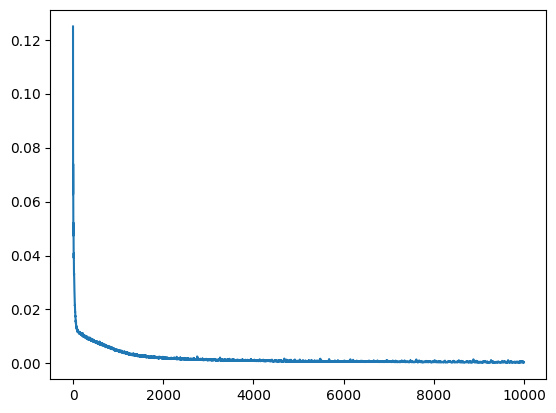

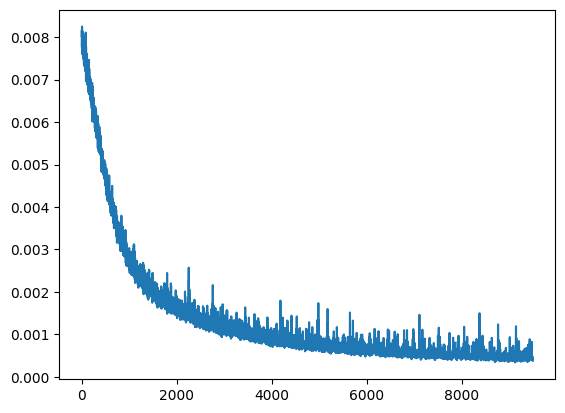

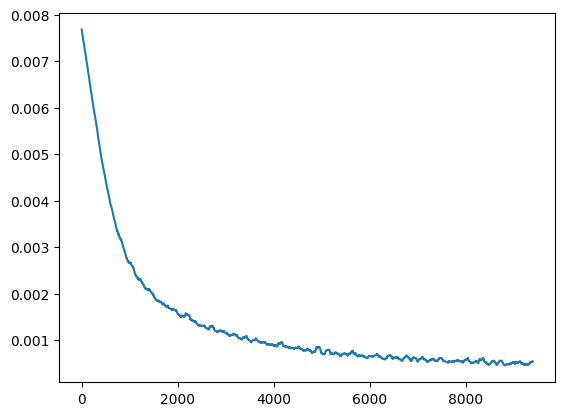

In [15]:
import matplotlib.pyplot as plt

# Plot the losses over training
plt.plot(list(range(len(mm_losses))), mm_losses, label='MM')
plt.show()

latter_training = mm_losses[500:]
plt.plot(list(range(len(latter_training))), latter_training, label='MM')
plt.show()

# running average of last 100 losses
latter_training_averaged = np.convolve(latter_training, np.ones((100,))/100, mode='valid')
plt.plot(list(range(len(latter_training_averaged))), latter_training_averaged, label='MM')
plt.show()

In [14]:
s0_batch = [s0 for s0, _, _ in mm_train_data]
s1_batch = [s1 for _, _, s1 in mm_train_data]
a_batch = [a for _, a, _ in mm_train_data]

s0_tensor = state_batch_to_tensor(s0_batch, device)
s1_tensor = state_batch_to_tensor(s1_batch, device)
a_tensor = action_batch_to_tensor(a_batch, device)

s1_pred = mm(s0_tensor, a_tensor)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0]
loss_y = loss[:, 1]
loss_theta = loss[:, 2] + loss[:, 3]

print("training loss", loss.mean().item())

training loss 0.00039682083297520876


In [13]:
s0_batch = [s0 for s0, _, _ in mm_validation_data]
s1_batch = [s1 for _, _, s1 in mm_validation_data]
a_batch = [a for _, a, _ in mm_validation_data]

s0_tensor = state_batch_to_tensor(s0_batch, device)
s1_tensor = state_batch_to_tensor(s1_batch, device)
a_tensor = action_batch_to_tensor(a_batch, device)

s1_pred = mm(s0_tensor, a_tensor)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0]
loss_y = loss[:, 1]
loss_theta = loss[:, 2] + loss[:, 3]

print("validation loss", loss.mean().item())

validation loss 0.00042138362186960876


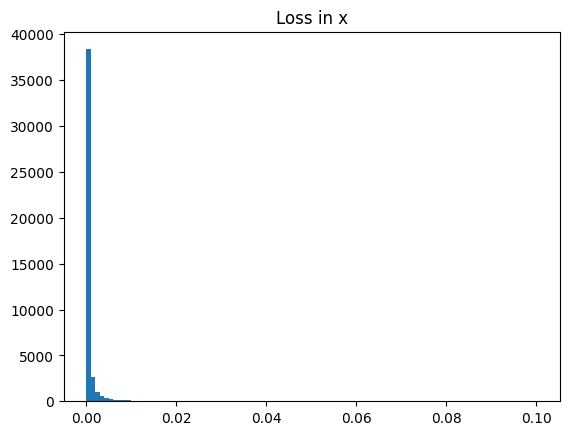

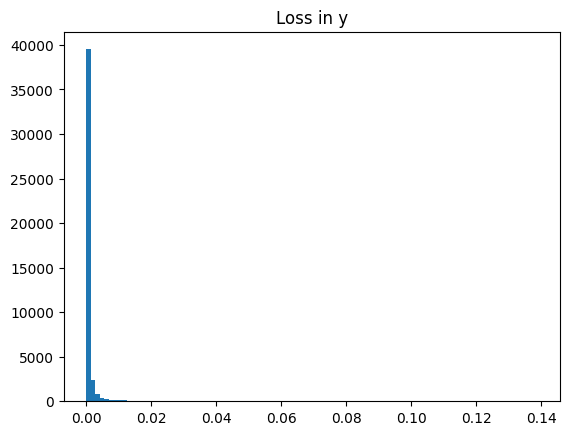

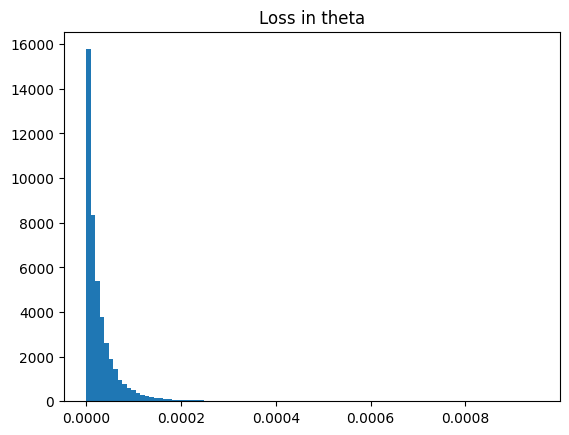

In [19]:
plt.hist(loss_x.cpu().detach().numpy(), bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y.cpu().detach().numpy(), bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta.cpu().detach().numpy(), bins=100)
plt.title('Loss in theta')
plt.show()


Now that we have trained a neural network model of Metadrive through which we can backprop, training the IDM is easy.

In [15]:
# creates a model that attempts to predict the action given the current state and the next state
class InverseDynamicsModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 4, 2)
        # output shape: (batch_size, 2)

        self.conv1 = nn.Conv1d(4, 768, 2) # Bx4x2 -> Bx768x1
        self.fc1 = nn.Linear(768, 768) # Bx768 -> Bx768
        self.fc2 = nn.Linear(768, 2) # Bx768 -> Bx2
    
    def forward(self, x: torch.Tensor):
        x = F.relu(self.conv1(x)) # Bx4x2 -> Bx768x1
        x = torch.flatten(x, 1) # Bx768x1 -> Bx768
        x = F.relu(self.fc1(x)) # Bx768 -> Bx768
        x = self.fc2(x) # Bx768 -> Bx2
        return x

def idm_train_batch(
        mm: MetadriveModel,
        idm: InverseDynamicsModel,
        idm_optimizer: torch.optim.Optimizer,
        obs_batch: list[Observation],
) -> float:
    device = deviceof(mm)

    assert deviceof(idm) == device

    obs_tensor = obs_batch_to_tensor(obs_batch, device)
    s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
    s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)

    idm_optimizer.zero_grad()

    pred_action = idm(obs_tensor)
    pred_s1 = mm(s0_tensor, pred_action)

    loss = F.mse_loss(pred_s1, s1_tensor)
    loss.backward()

    idm_optimizer.step()

    return float(loss.item())

In [18]:
import itertools

idm_train_iter = itertools.cycle(idm_train_data)

idm = InverseDynamicsModel().to(device)

idm_optimizer = torch.optim.AdamW(idm.parameters())

idm_step = 0
idm_losses = []

In [31]:
set_lr(idm_optimizer, 1e-4)
INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS = 5000
INVERSE_DYNAMICS_MODEL_TRAIN_BATCH_SIZE = 4096

while idm_step < INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS:
    obs_batch = [next(idm_train_iter) for _ in range(INVERSE_DYNAMICS_MODEL_TRAIN_BATCH_SIZE)]
    loss = idm_train_batch(
        mm,
        idm,
        idm_optimizer,
        obs_batch,
    )
    idm_losses.append(loss)
    idm_step += 1
    if idm_step % 100 == 0:
        # print average loss over last 100 steps
        loss = np.mean(idm_losses[-100:])
        print(f"Step: {idm_step}, Loss: {loss:.4f}")

Step: 4100, Loss: 0.0006
Step: 4200, Loss: 0.0005


KeyboardInterrupt: 

In [16]:
# load idm
if 'idm' not in locals():
    idm = InverseDynamicsModel().to(device)
    idm.load_state_dict(torch.load('waymo_data/idm.pth'))    

RuntimeError: Error(s) in loading state_dict for InverseDynamicsModel:
	Missing key(s) in state_dict: "conv1.weight", "conv1.bias". 
	Unexpected key(s) in state_dict: "fc3.weight", "fc3.bias". 
	size mismatch for fc1.weight: copying a param with shape torch.Size([768, 6]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([2, 768]).
	size mismatch for fc2.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([2]).

In [41]:
# save idm
if not os.path.exists('waymo_data/idm.pth'):
    torch.save(idm.state_dict(), 'waymo_data/idm.pth')

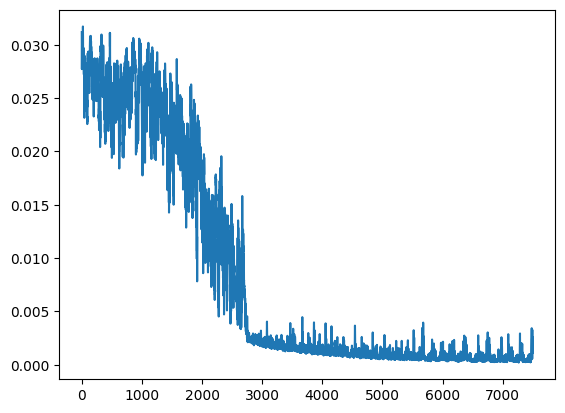

In [26]:
import matplotlib.pyplot as plt

# Plot the losses over training
plt.plot(list(range(len(idm_losses))), idm_losses, label='IDM')
plt.show()

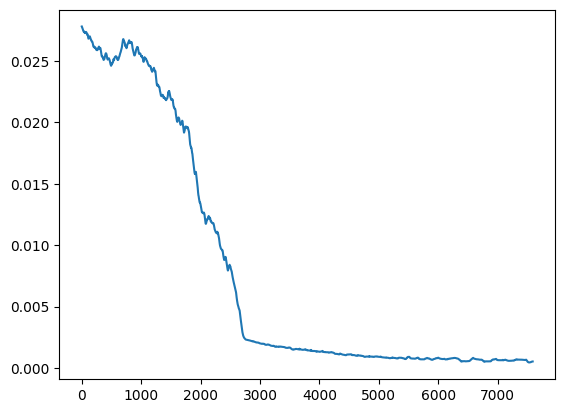

In [35]:
# compute running average of the last 200 episodes
# plot the average reward per episode
idm_losses_averaged = np.convolve(idm_losses, np.ones((200,))/200, mode='valid')
plt.plot(idm_losses_averaged)

Let' compare our trained IDM against the null idm (predicts 0 for all values):

In [32]:
obs_batch = idm_train_data

obs_tensor = obs_batch_to_tensor(obs_batch, device)
s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)
with torch.no_grad():
    action_pred = idm(obs_tensor)
    s1_pred = mm(s0_tensor, action_pred)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0].cpu().detach().numpy()
loss_y = loss[:, 1].cpu().detach().numpy()
loss_theta = loss[:, 2].cpu().detach().numpy()

print("training loss", loss.mean().item())

training loss 0.00036402951809577644


In [33]:
obs_batch = idm_validation_data

obs_tensor = obs_batch_to_tensor(obs_batch, device)
s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)
with torch.no_grad():
    action_pred = idm(obs_tensor)
    s1_pred = mm(s0_tensor, action_pred)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0].cpu().detach().numpy()
loss_y = loss[:, 1].cpu().detach().numpy()
loss_theta = loss[:, 2].cpu().detach().numpy()

print("validation loss", loss.mean().item())

validation loss 0.0003399495908524841


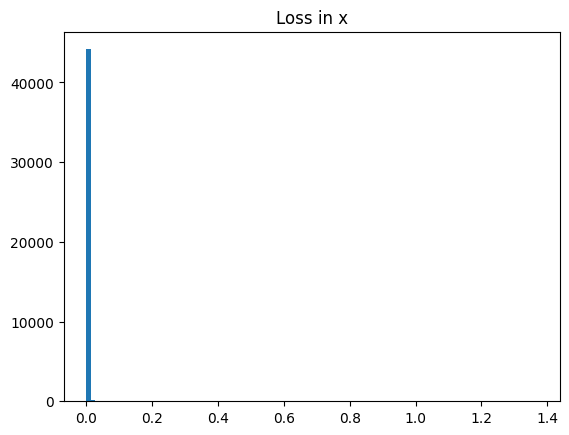

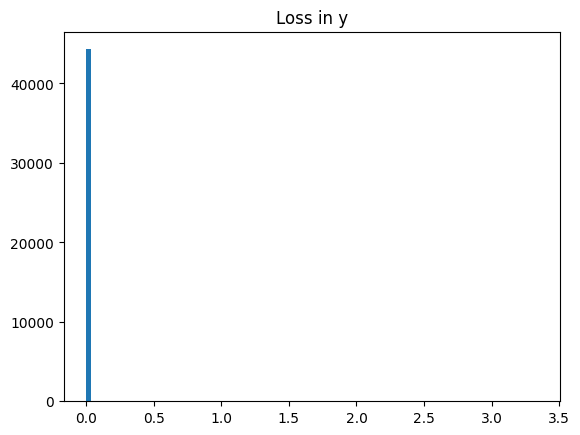

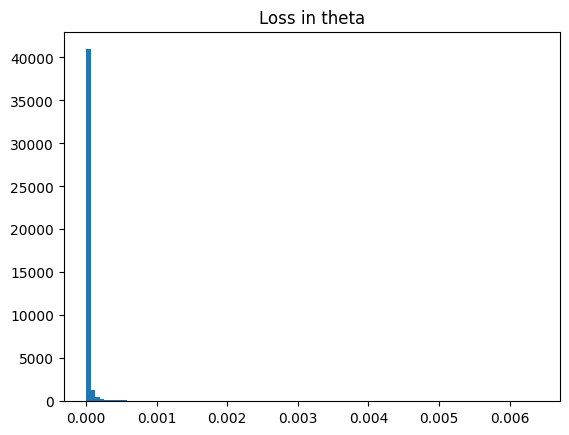

In [36]:
plt.hist(loss_x, bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y, bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta, bins=100)
plt.title('Loss in theta')
plt.show()


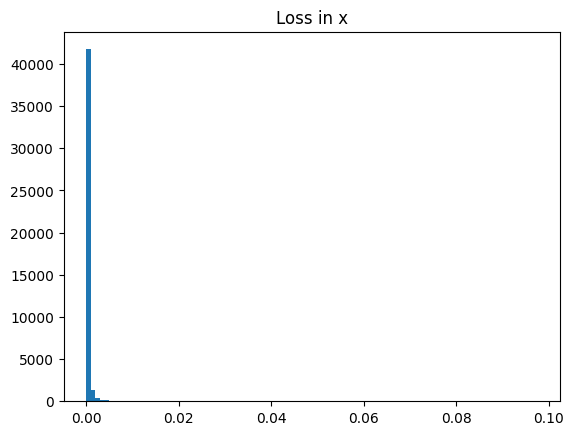

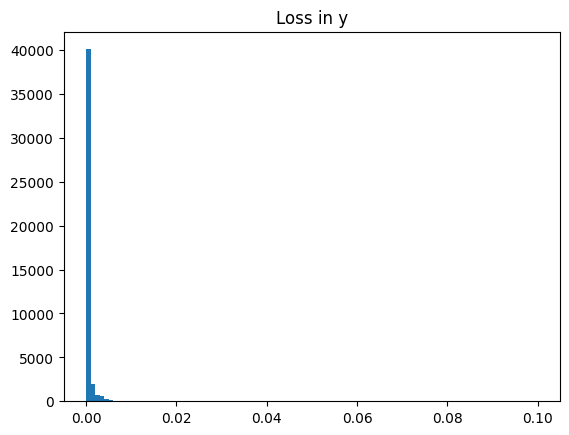

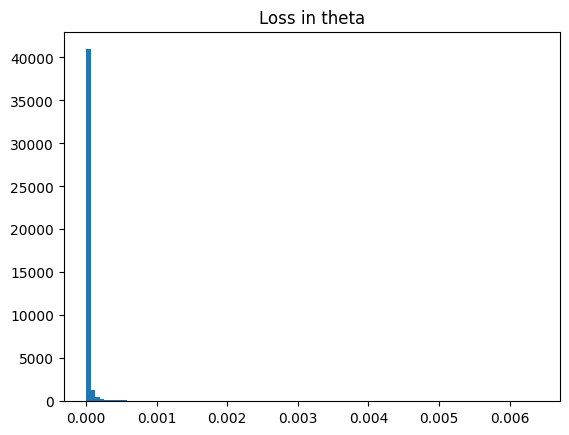

In [37]:
loss_x_no_outliers = np.array([x for x in loss_x if x < 0.1 ]) 
loss_y_no_outliers = np.array([x for x in loss_y if x < 0.1 ])
loss_theta_no_outliers = np.array([x for x in loss_theta if x < 0.1 ])

plt.hist(loss_x_no_outliers, bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y_no_outliers, bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta_no_outliers, bins=100)
plt.title('Loss in theta')
plt.show()


Let's try visualizing our IDM by having it follow a track from start to finish.

In [38]:
class IDMPolicy:
    def __init__(self, net: InverseDynamicsModel):
        self.net = net

    def __call__(self, obs:Observation) -> Action:
        # sample an action from the policy network
        obs_tensor = obs_batch_to_tensor([obs], deviceof(self.net))
        # sample an action from the policy network
        with torch.no_grad():
            steering, throttle = self.net(obs_tensor)[0]
        return steering.item(), throttle.item()


In [32]:
env = gym.make("MetaDrive-validation-v0", config={"on_continuous_line_done": False, "use_render": True})

In [33]:
scenario = trajectories[0]
with torch.no_grad():
    # reset
    env.reset()

    # allow car to settle
    for _ in range(10):
        env.step([0,0])

    st = scenario[0]

    # set the initial state
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)


    for i in range(len(scenario)-1):
        st0 = scenario[i]
        st1 = scenario[i+1]
        st0_pred = get_metadrive_state(env)
        action = IDMPolicy(idm)((st0_pred, st1))
        env.step(action)
        st1_pred = get_metadrive_state(env)
        print(action)
        print(st1_pred.velocity, st1_pred.heading, st1.velocity, st1.heading)
        

/home/fidgetsinner/venvs/metadrive/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:210: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
Known pipe types:
  glxGraphicsPipe
(1 aux display modules not yet loaded.)
:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/event23 is not readable, some features will be unavailable.


(-0.004349745810031891, -0.00658010970801115)
[ 8.52707863 -0.89150143] -0.10208655459184435 [ 8.434904  -0.8993066] -0.10308719426393509
(-0.01025761105120182, -0.24361279606819153)
[ 8.13075161 -0.8702448 ] -0.10327472391218251 [ 8.238273   -0.88254017] -0.10458064079284668
(-0.014247262850403786, 0.011446897871792316)
[ 8.13043976 -0.90104467] -0.10552323082053672 [ 8.038336   -0.88226646] -0.10596421360969543
(-0.006228474900126457, -0.2647111713886261)
[ 7.70217657 -0.85665822] -0.10804511121478733 [ 7.8264923  -0.86863965] -0.10708256810903549
(-0.008808402344584465, 0.02374834194779396)
[ 7.70670986 -0.87484157] -0.10984420968919029 [ 7.6220136  -0.84843785] -0.10836736112833023
(-0.003332151100039482, -0.24923846125602722)
[ 7.30398798 -0.82830608] -0.11141507525817396 [ 7.418258  -0.8321308] -0.10931422561407089
(-0.005708759650588036, 0.009704937227070332)
[ 7.30536318 -0.83974504] -0.11245464018968576 [ 7.2167773 -0.8089041] -0.10959555208683014
(-0.0005357284680940211, -0.2

INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.010061590000987053, 0.3821660280227661)
[0.37519947 5.55115604] 1.4978614076077106 [0.3620588 5.575738 ] 1.5021787881851196


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.011217733845114708, 0.3792664110660553)
[0.37459952 5.65619278] 1.500007482682638 [0.37354338 5.6789627 ] 1.5032975673675537


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.007325528189539909, 0.3550545275211334)
[0.40210316 5.74820948] 1.5017375803176725 [0.3802775 5.770196 ] 1.5040465593338013


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.015015138313174248, 0.3518582880496979)
[0.36116591 5.83976889] 1.5032160425192087 [0.38664845 5.861693  ] 1.5046573877334595


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00382283516228199, 0.35848191380500793)
[0.35975888 5.88947201] 1.505005254008064 [0.39357695 5.9543447 ] 1.5050568580627441


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006354542449116707, 0.42756685614585876)
[0.36285481 5.94843483] 1.5065621504648927 [0.4004763 6.041934 ] 1.5052820444107056


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00989091582596302, 0.46741148829460144)
[0.39816955 6.06237745] 1.5076911227076257 [0.41156766 6.1225724 ] 1.5051860809326172


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0015926677733659744, 0.4121347963809967)
[0.4036954  6.17607832] 1.5073216548794584 [0.42153323 6.206927  ] 1.504749059677124


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005133325234055519, 0.3526444733142853)
[0.40840024 6.22987366] 1.5070079511478038 [0.43402797 6.286877  ] 1.5044056177139282


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003926688805222511, 0.3877698481082916)
[0.41290402 6.2832365 ] 1.506641300444727 [0.43781155 6.3602657 ] 1.5041756629943848


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0028358418494462967, 0.4343007802963257)
[0.42077813 6.37887669] 1.506286496647312 [0.44207415 6.4396915 ] 1.5035043954849243


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008379580453038216, 0.41070714592933655)
[0.44513169 6.49085951] 1.5055488634431988 [0.46385005 6.5214725 ] 1.5025402307510376


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002215960994362831, 0.3417220413684845)
[0.44735411 6.58530235] 1.5044689266540363 [0.472288  6.5940113] 1.5018751621246338


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0009103213087655604, 0.2955791652202606)
[0.45079479 6.66688538] 1.5039360738929926 [0.4758818 6.661564 ] 1.5011874437332153


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004367085173726082, 0.27539679408073425)
[0.46477798 6.74214649] 1.5035169214657387 [0.4903972 6.730551 ] 1.5003000497817993


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004012526944279671, 0.26026391983032227)
[0.47433847 6.81352901] 1.5028264303741077 [0.50146914 6.7965508 ] 1.4995455741882324


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004287654533982277, 0.233280748128891)
[0.48445958 6.87739754] 1.502067862227113 [0.51098305 6.8514752 ] 1.4988337755203247


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003771798685193062, 0.20381538569927216)
[0.49268299 6.93324423] 1.5012853963705233 [0.5190603 6.897399 ] 1.4976098537445068


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.007330896332859993, 0.1846439391374588)
[0.51043069 6.98305511] 1.500372369041492 [0.5368797 6.940908 ] 1.4963221549987793


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005418943241238594, 0.16984663903713226)
[0.51921624 7.02944756] 1.4991757691518277 [0.547153  6.9817133] 1.4954941272735596


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004042530432343483, 0.16771309077739716)
[0.52634513 7.07536793] 1.498139117052757 [0.55245495 7.0265555 ] 1.494631052017212


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0052368734031915665, 0.16407981514930725)
[0.53827053 7.11990595] 1.4972199519696519 [0.5638121 7.0697184] 1.4934890270233154


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00391949899494648, 0.14642754197120667)
[0.54545772 7.15992069] 1.4962784995571736 [0.5712877 7.103415 ] 1.492586374282837


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0023469049483537674, 0.13268238306045532)
[0.54959041 7.19635868] 1.4955287864208024 [0.57411957 7.135037  ] 1.4920015335083008


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0018086601048707962, 0.13446888327598572)
[0.55424905 7.23324871] 1.4950095282648856 [0.57760185 7.17233   ] 1.4915282726287842


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0018348414450883865, 0.12790603935718536)
[0.55975515 7.26825285] 1.4946035127119464 [0.5824695 7.205048 ] 1.4913051128387451


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0007109065190888941, 0.11069802194833755)
[0.56188625 7.29874945] 1.494279222914959 [0.5842667 7.2296395] 1.491066336631775


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0016080010682344437, 0.11379799991846085)
[0.567725   7.32981634] 1.4940416772681022 [0.5898651 7.261667 ] 1.4905669689178467


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0022233594208955765, 0.12050596624612808)
[0.57452458 7.36266375] 1.4937085740723823 [0.5974232 7.296478 ] 1.4902881383895874


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0007851739064790308, 0.10633476823568344)
[0.57632643 7.39197779] 1.4933574695721692 [0.5992058 7.320796 ] 1.4901599884033203


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0009606052772141993, 0.09342751652002335)
[0.57984275 7.41758108] 1.4931347044693624 [0.6018444 7.342322 ] 1.4898490905761719


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003813626244664192, 0.08845198899507523)
[0.5910306  7.44118786] 1.4927871785918638 [0.61347663 7.364597  ] 1.4895634651184082


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0003761331900022924, 0.07674383372068405)
[0.58747971 7.46272755] 1.492329081594856 [0.610853  7.3816657] 1.4894236326217651


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00025526987155899405, 0.06707777827978134)
[0.58813858 7.48125839] 1.492252815319139 [0.60927975 7.3973536 ] 1.4890722036361694


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002983706071972847, 0.056386593729257584)
[0.59795725 7.49608994] 1.4921095372524933 [0.6192652 7.4091196] 1.4888473749160767


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0012967605143785477, 0.05335307493805885)
[0.59953189 7.51074457] 1.4917038129827977 [0.6225402 7.4223228] 1.4887633323669434


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0012981165200471878, 0.05003753677010536)
[0.60246551 7.52436972] 1.4913931136297478 [0.6247261 7.434896 ] 1.4883527755737305


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0015918631106615067, 0.029743317514657974)
[0.60594112 7.5323348 ] 1.4910965207080977 [0.6281461 7.4360304] 1.487992525100708


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0007553715840913355, 0.023302678018808365)
[0.60668021 7.53873491] 1.4908158651410952 [0.62890315 7.440082  ] 1.4878284931182861


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0008232574327848852, 0.03450663760304451)
[0.60421008 7.548491  ] 1.4907048030012602 [0.6258966 7.4534307] 1.4876474142074585


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0019219834357500076, 0.029372546821832657)
[0.61105639 7.55607176] 1.4906608941327875 [0.6322214 7.4598117] 1.4872727394104004


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002320738509297371, 0.018752265721559525)
[0.61600029 7.56086063] 1.4903358886112574 [0.63881236 7.460815  ] 1.487014651298523


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0013538170605897903, 0.018702272325754166)
[0.61737907 7.56593323] 1.4899392690235382 [0.64082336 7.4655676 ] 1.4865072965621948


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003727557137608528, 0.016448084264993668)
[0.62635058 7.56974506] 1.4895009210304897 [0.64963573 7.469003  ] 1.4858983755111694


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0029069948941469193, 0.012751881964504719)
[0.63047385 7.57293653] 1.4888524329826769 [0.6551945 7.4705596] 1.4854170083999634


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.001931922510266304, 0.011154462583363056)
[0.63248998 7.57586336] 1.4882777727537082 [0.6567713 7.4728165] 1.48493230342865


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004175784066319466, 0.010353912599384785)
[0.64194757 7.57792616] 1.4877097870722222 [0.6659616 7.474974 ] 1.4842092990875244


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0037993062287569046, 0.0005937861278653145)
[0.64782244 7.5775876 ] 1.4869342412732776 [0.6731201 7.471108 ] 1.4835487604141235


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004146130755543709, -0.01011065673083067)
[0.65337735 7.5605998 ] 1.486120437500798 [0.68002975 7.463939  ] 1.4824882745742798


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.007615434005856514, 0.01852429285645485)
[0.66991818 7.56424093] 1.4850852002060568 [0.6970284 7.464101 ] 1.481090784072876


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006338285282254219, 0.021079156547784805)
[0.67943877 7.56923437] 1.483700065155971 [0.7092838 7.469378 ] 1.4796779155731201


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006765903905034065, 0.022809911519289017)
[0.69102818 7.57450342] 1.4823249336047306 [0.7214383 7.4752617] 1.4779852628707886


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.011962564662098885, 0.017014775425195694)
[0.71675593 7.57672882] 1.4806444872792692 [0.7491052 7.4764233] 1.475792407989502


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.011471787467598915, 0.012234692461788654)
[0.73509765 7.57834005] 1.4783732935673788 [0.77207625 7.4757066 ] 1.4735686779022217


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.01114647276699543, 0.0203871913254261)
[0.75276864 7.58224773] 1.4760025142754767 [0.79118854 7.4819965 ] 1.4708153009414673


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.014647694304585457, 0.017636258155107498)
[0.78067267 7.58422565] 1.473460743396835 [0.82020426 7.4831395 ] 1.4676357507705688


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.014677407220005989, 0.0018559442833065987)
[0.80453908 7.58219576] 1.4705123161421163 [0.84605974 7.474864  ] 1.464428186416626


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.014045732095837593, -0.005143950693309307)
[0.82524872 7.57152891] 1.4674802073725202 [0.8674576 7.4683237] 1.4610859155654907


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.016444647684693336, 0.006522570736706257)
[0.85430622 7.57003212] 1.4643707753851487 [0.89581454 7.464253  ] 1.4575517177581787


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.022154325619339943, 0.628970205783844)
[0.91739416 7.73733664] 1.4606830962237165 [0.97439575 7.8286557 ] 1.454150676727295


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.014108540490269661, 0.33547237515449524)
[0.94257724 7.82770348] 1.4566056301472372 [1.0007105 7.824476 ] 1.4501720666885376


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.02182593382894993, -0.35993796586990356)
[0.91403311 7.24107933] 1.4528957968144862 [0.9801815 7.4469185] 1.4465347528457642


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.012861819937825203, 0.5156944394111633)
[0.94173884 7.38119888] 1.4491317182192818 [1.0048403 7.4337683] 1.4430122375488281


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.016697021201252937, 0.2509026527404785)
[0.97974133 7.44605637] 1.4459678828442675 [1.0309957 7.418855 ] 1.4394099712371826


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.01622726209461689, 0.11942438036203384)
[1.00922263 7.47535896] 1.4425893550735012 [1.0548108 7.4065995] 1.4359744787216187


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0131749976426363, 0.04537852481007576)
[1.0278033  7.48549557] 1.4393500107592043 [1.0686216 7.392741 ] 1.4328243732452393


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.014148147776722908, 0.010139022953808308)
[1.05153847 7.48499107] 1.4364112457858162 [1.0865757 7.3816743] 1.4297406673431396


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.014013992622494698, -0.027852650731801987)
[1.06712878 7.43699026] 1.4334679534385737 [1.1034591 7.3580446] 1.4271507263183594


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.011306533589959145, -0.012522722594439983)
[1.07854593 7.41477728] 1.4306811134829953 [1.1112282 7.321081 ] 1.4251453876495361


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010598288848996162, -0.018654193729162216)
[1.08933282 7.38252974] 1.4282495308944556 [1.119783  7.2954016] 1.4231305122375488


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.009651260450482368, -0.01916758343577385)
[1.09848583 7.34965086] 1.4260420533116456 [1.1269426 7.2634296] 1.4212298393249512


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006007330492138863, -0.036061014980077744)
[1.09459484 7.29094124] 1.4241790223263244 [1.1234672 7.2193995] 1.4198884963989258


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003335343673825264, 0.005239118821918964)
[1.09655344 7.2921195 ] 1.4229129222545867 [1.1186031 7.18772  ] 1.4190253019332886


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005789974704384804, -0.02691999450325966)
[1.10144389 7.24707699] 1.4219546836048629 [1.1238579 7.168662 ] 1.4184162616729736


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0006185044185258448, 0.002291549928486347)
[1.09674001 7.24843216] 1.4210967795492069 [1.1168487 7.142894 ] 1.4180843830108643


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0016843434423208237, -0.050180625170469284)
[1.07909405 7.16854   ] 1.4208846920578964 [1.1016587 7.107734 ] 1.4178439378738403


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00033759133657440543, 0.017428789287805557)
[1.08079648 7.17315197] 1.421012790106329 [1.0971261 7.0731707] 1.417784571647644


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-3.49624315276742e-06, -0.05529840663075447)
[1.06835043 7.08406734] 1.421084046310245 [1.0891622 7.029178 ] 1.418238639831543


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0058144088834524155, 0.004735802300274372)
[1.05356514 7.08755732] 1.4213855161456426 [1.0682238 6.981581 ] 1.4189802408218384


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0031838472932577133, -0.054985057562589645)
[1.03842747 6.99938917] 1.4221814018374124 [1.0552435 6.9432235] 1.4196984767913818


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004814354702830315, 0.010441412217915058)
[1.03068352 7.00343704] 1.4229369239939107 [1.0425911 6.900482 ] 1.4208993911743164


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009949436411261559, -0.053234536200761795)
[0.99847859 6.92054605] 1.4240731450282365 [1.0130278 6.8584895] 1.4226435422897339


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.010316809639334679, 0.008271818049252033)
[0.98398167 6.9248991 ] 1.4258077950042596 [0.9907559 6.8194323] 1.4243123531341553


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.005988983437418938, -0.06150451675057411)
[0.96725821 6.82624626] 1.427537418263725 [0.9781727 6.775305 ] 1.4261763095855713


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.01332053355872631, 0.017669234424829483)
[0.9425596  6.83450174] 1.4291876626779496 [0.94930357 6.7309766 ] 1.4286128282546997


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.01496150903403759, -0.04299246892333031)
[0.91057664 6.76820612] 1.4315655492810109 [0.9159944 6.6952453] 1.430959939956665


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.013279033824801445, 0.0013860510662198067)
[0.89548314 6.77060366] 1.4342070638648554 [0.8954789 6.661403 ] 1.4333573579788208


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0136698167771101, -0.0584581159055233)
[0.86575013 6.67857695] 1.4367764317502933 [0.87109745 6.6203575 ] 1.4364244937896729


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.015999479219317436, -0.00085399579256773)
[0.84294391 6.68002605] 1.4394432630092497 [0.8422627 6.570067 ] 1.4395867586135864


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.01609758846461773, -0.08372697979211807)
[0.80562079 6.54739666] 1.4423443192860788 [0.8108911 6.5105   ] 1.4424134492874146


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.01849949173629284, 0.004360769875347614)
[0.78064805 6.55154705] 1.4453911004088056 [0.7777926 6.442143 ] 1.4453397989273071


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.01644757203757763, -0.10042987018823624)
[0.74417043 6.39135695] 1.448589082502421 [0.748836  6.3705564] 1.4485033750534058


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.018280280753970146, 0.028325963765382767)
[0.72226948 6.40168333] 1.4516840085842295 [0.72051793 6.303883  ] 1.4518581628799438


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0158087145537138, -0.07075242698192596)
[0.69426215 6.28901911] 1.4547957541927978 [0.69555324 6.2439604 ] 1.455466628074646


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.023643745109438896, 0.005681072361767292)
[0.65905911 6.29415035] 1.458005595675643 [0.6583061 6.186466 ] 1.4592466354370117


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.02135859988629818, -0.47174492478370667)
[0.55982846 5.53297472] 1.4617344872549447 [0.59079194 5.821496  ] 1.4625822305679321


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.01742076687514782, 0.5653784871101379)
[0.5647431  5.68944693] 1.4650078451297883 [0.5715151 5.759868 ] 1.4657378196716309


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.023068590089678764, 0.7315334677696228)
[0.55689764 5.89303017] 1.4681737610994041 [0.5745472 6.0089407] 1.4696050882339478


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.019762201234698296, 0.2416744828224182)
[0.5468756  5.96100378] 1.471698979111963 [0.5464605 5.9409966] 1.4734573364257812


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.021636245772242546, -0.01358273159712553)
[0.52179152 5.94101286] 1.4751336912593525 [0.5161228 5.8516   ] 1.4766303300857544


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.02000759355723858, -0.1063835471868515)
[0.48920217 5.77013683] 1.478591206723575 [0.4891262 5.763084 ] 1.4797364473342896


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.018852291628718376, 0.002819967456161976)
[0.47319889 5.77225018] 1.4818280709691054 [0.46350002 5.675158  ] 1.483239769935608


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.020535459741950035, -0.12405175715684891)
[0.43640971 5.572721  ] 1.4849700767455598 [0.4375123 5.5824533] 1.4867311716079712


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.01833110861480236, 0.02915458008646965)
[0.42323539 5.58182001] 1.4880697632278164 [0.4120396 5.497944 ] 1.4900721311569214


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.02065492980182171, -0.08478771895170212)
[0.39288557 5.44571638] 1.4910758978544063 [0.3887844 5.4226403] 1.4933497905731201


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.01907402090728283, -0.01278222631663084)
[0.37701732 5.42599344] 1.4941204152902063 [0.36530218 5.3411155 ] 1.4968369007110596


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.023803194984793663, -0.1102311834692955)
[0.34066814 5.24861336] 1.4972109138667022 [0.33603942 5.247472  ] 1.5001779794692993


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.016013091430068016, -3.645848482847214e-05)
[0.33595836 5.24892378] 1.5003104838356611 [0.31829196 5.1539836 ] 1.5032390356063843


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.018529249355196953, -0.10944399237632751)
[0.30956358 5.07217932] 1.5029443127030468 [0.30060983 5.073081  ] 1.5064431428909302


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0128611009567976, 0.08976415544748306)
[0.307614   5.09717178] 1.5053743722963384 [0.28924456 5.0363884 ] 1.5096673965454102


In [34]:
env.close()

In [35]:
env = MetaDriveEnv(config={"on_continuous_line_done": False, "use_render": False})

In [36]:
def compute_loss(s_pred: State, s_true:State) -> float:
    """
    Computes the loss between the predicted state and the true state
    """
    vel_error = np.linalg.norm(s_pred.velocity - s_true.velocity) ** 2
    heading_error = normalize_angle(s_pred.heading - s_true.heading) ** 2
    return float(vel_error + heading_error)


def run_game(env: MetaDriveEnv, policy:typing.Callable[[Observation], Action], o: Observation) -> tuple[Action, float, State]:
    s0, s1 = o
    a = policy(o)
    s1_pred = next_state(env, s0, a)
    r = -compute_loss(s1, s1_pred)
    return a, r, s1_pred

def run_game_est(mm:MetadriveModel, policy:typing.Callable[[Observation], Action], o: Observation) -> tuple[Action, float, State]:
    device = deviceof(mm)
    s0, s1 = o
    a = policy(o)
    with torch.no_grad():
        s1_pred_tensor = mm(state_batch_to_tensor([s0],device), action_batch_to_tensor([a],device)).detach().cpu().numpy()[0]
    s1_pred = State(velocity=s1_pred_tensor[:2], heading=np.arctan2(s1_pred_tensor[3], s1_pred_tensor[2]))
    r = -compute_loss(s1, s1_pred)
    return a, r, s1_pred


In [37]:
import random
random.seed(42)
idm_test_set = random.sample(idm_train_data, 500)

:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager


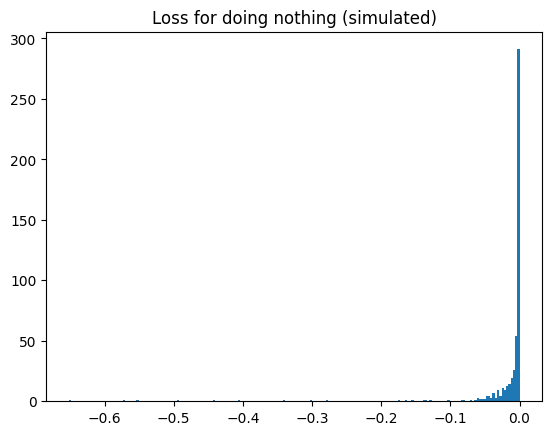

mean -0.017627463025231365
median -0.001938828260729241


In [38]:
def null_policy(_:Observation) -> tuple[float, float]:
    return 0, 0

# test loss function
do_nothing_loss = []
for s0, s1 in idm_test_set:
    _, rew, _ = run_game(env, null_policy, (s0, s1))
    do_nothing_loss.append(rew)

plt.title("Loss for doing nothing (simulated)")
plt.hist(do_nothing_loss, bins=200)
plt.show()
print("mean", np.mean(do_nothing_loss))
print("median", np.median(do_nothing_loss))

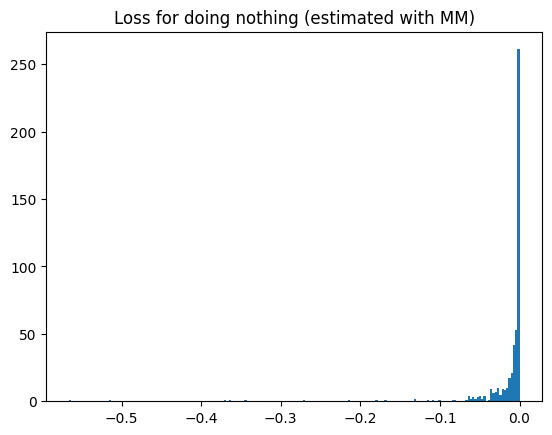

mean -0.015582012210021642
median -0.0022155420079017635


In [40]:
# test loss function
do_nothing_loss_est = []
for s0, s1 in idm_test_set:
    _, rew, pred_s1 = run_game_est(mm, null_policy, (s0, s1))
    do_nothing_loss_est.append(rew)

plt.title("Loss for doing nothing (estimated with MM)")
plt.hist(do_nothing_loss_est, bins=200)
plt.show()
print("mean", np.mean(do_nothing_loss_est))
print("median", np.median(do_nothing_loss_est))

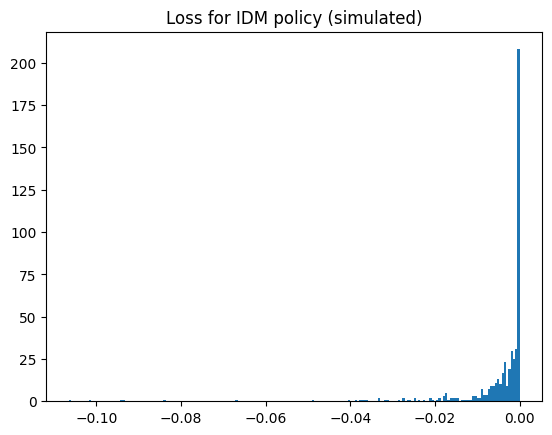

mean -0.005120855363588924
median -0.0012659258577911057


In [41]:
# test loss function
idm_loss = []
for s0, s1 in idm_test_set:
    _, rew, _ = run_game(env, IDMPolicy(idm), (s0, s1))
    idm_loss.append(rew)

plt.title("Loss for IDM policy (simulated)")
plt.hist(idm_loss, bins=200)
plt.show()
print("mean", np.mean(idm_loss))
print("median", np.median(idm_loss))

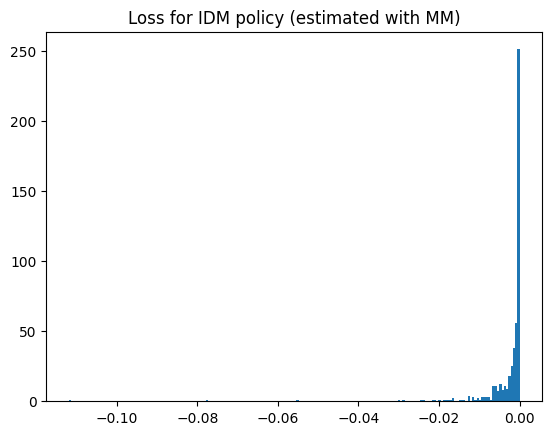

mean -0.002699028017411931
median -0.0005439686094454339


In [42]:
# test loss function
idm_loss_est = []
for s0, s1 in idm_test_set:
    _, rew, _ = run_game_est(mm, IDMPolicy(idm), (s0, s1))
    idm_loss_est.append(rew)

plt.title("Loss for IDM policy (estimated with MM)")
plt.hist(idm_loss_est, bins=200)
plt.show()
print("mean", np.mean(idm_loss_est))
print("median", np.median(idm_loss_est))

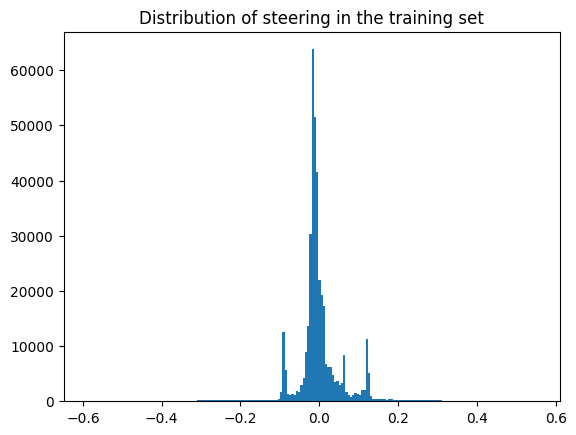

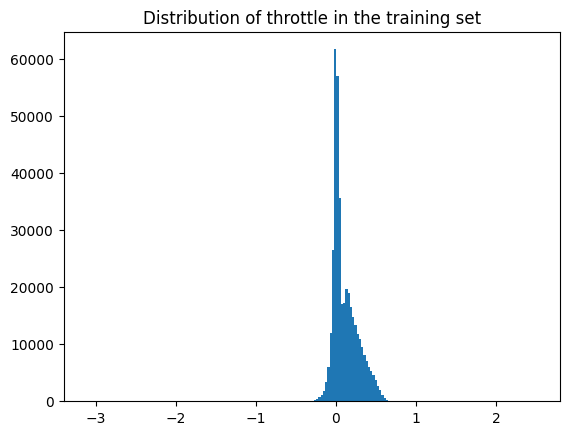

In [39]:
plt.title("Distribution of steering in the training set")
plt.hist(action_pred[:, 0].cpu().detach().numpy(), bins=200)
plt.show()

plt.title("Distribution of throttle in the training set")
plt.hist(action_pred[:, 1].cpu().detach().numpy(), bins=200)
plt.show()